# Motorica Internship, Sprint 2

## ENC Model 

The aim is to develop a NN model to predict the values of the ENC0..ENC4 signals of glove encoders. These signals represent measurements of the straightening or contracting of the pilot's fingers.  The idea is to build the NN model without regard to the pilot's hand pronation.

In [15]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# uncomment for interactive graph
#%matplotlib widget

# IO utils


In [16]:
def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int, 
                 n_acc_channels: int = 0, 
                 n_gyr_channels: int = 0, 
                 n_mag_channels: int = 0, 
                 n_enc_channels: int = 0,
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns = columns + ['BUTTON']
        
    if sync_ch:
        columns = columns + ['SYNC']
        
    if timestamp_ch:
        columns = columns + ['ts']
        
    df_raw.columns = columns
    
    return df_raw

# Abbreviations
OMG — optomiography  
ACC — accelerometer  
GYR — gyroscope  
ENC - encoders (fingers of prosthesis or gloves)  
model — model of data  

# Data

In [17]:
palm_file = './sprint2_pilote1_gestures.palm'   #'./Data/sprint2_pilote1_gestures.palm'   './Data/sprint2_pilote1_fingers.palm'
TRAIN_PART = 0.8 
VALIDATION_PART = 0.15   #Validation during NN training
gestures_train = read_omg_csv(palm_file, 
                              n_omg_channels=50,
                              n_acc_channels=3, 
                              n_gyr_channels=3, 
                              n_enc_channels=6, 
                              n_mag_channels=0)

print("Observations shape:", gestures_train.shape)
train_size = round(gestures_train.shape[0]*TRAIN_PART)
print("Train size", train_size, "Test size",gestures_train.shape[0]-train_size)
gestures_train.head()

Observations shape: (37610, 65)
Train size 30088 Test size 7522


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,10,8,29,2846,2929,2873,2598,24,8,6,...,32,37,50,54,44,5,0,0,0,1174956
1,10,8,28,2846,2931,2873,2597,24,8,13,...,31,37,50,54,44,5,0,0,0,1174989
2,16,8,29,2847,2930,2875,2598,24,8,6,...,31,37,50,54,44,5,0,0,0,1175022
3,10,8,29,2847,2930,2875,2598,25,8,5,...,30,37,50,54,44,5,0,0,0,1175055
4,0,8,29,2845,2927,2870,2594,24,8,6,...,30,37,50,54,44,5,0,0,0,1175088


In [18]:
# [X features] '0', ..., '49' - каналы OMG датчиков
#              'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
#              'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
# [y target]   'ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5' - координаты пальцев в перчатке GLOVE
# 'BUTTON' - не используется
# 'SYNC' - синхронизация данных с протоколом
# 'ts' - метка времени
gestures_train.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

In [19]:
OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4'] #ENC5 is empty
GLOVE_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']  #ENC5 is empty
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']
FINGERS = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']

assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(GLOVE_CH)+len(BUTTON_SYNC_TS_CH) == gestures_train.shape[-1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"GLOVE_CH: {list(GLOVE_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")
print("Fingers:", FINGERS)

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
GLOVE_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']
Fingers: ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']


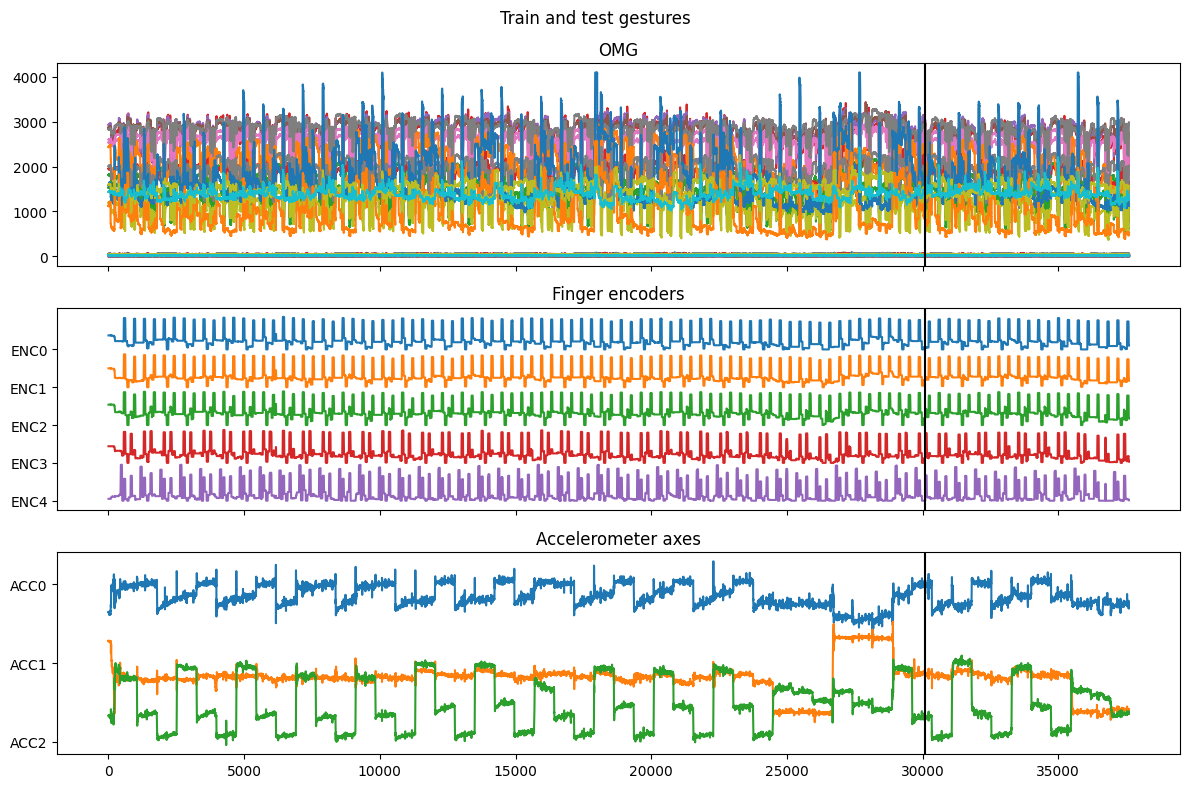

In [20]:
fig, axx = plt.subplots(3, 1, sharex=True, figsize=(12, 8))
xax = np.arange(gestures_train.shape[0])
plt.sca(axx[0])
plot_train = plt.plot(xax, gestures_train[OMG_CH].values)
#plot_train = plt.plot(gestures_train['ts'].values, gestures_train[OMG_CH].values)
plt.axvline(train_size, color='k', label='Train-Test split')
plt.title('OMG')
#plt.legend()

plt.sca(axx[1])
plot_train = plt.plot(xax, gestures_train[ENC_CH].values - np.arange(len(ENC_CH)) * 100)
#plot_train = plt.plot(gestures_train['ts'].values, gestures_train[GLOVE_CH].values - np.arange(len(GLOVE_CH)) * 100)
plt.axvline(train_size, color='k', label='Train-Test split')
plt.yticks(-np.arange(len(ENC_CH)) * 100, ENC_CH)
#plt.legend()
plt.title('Finger encoders')
#plt.xlabel('Timesteps')

plt.sca(axx[2])
plot_train = plt.plot(xax, gestures_train[ACC_CH].values - np.arange(len(ACC_CH)) * 200)
plt.axvline(train_size, color='k', label='Train-Test split')
plt.yticks(-np.arange(len(ACC_CH)) * 200, ACC_CH)
#plt.legend()
plt.title('Accelerometer axes')
#plt.xlabel('Timesteps')


plt.suptitle('Train and test gestures')
plt.tight_layout()

# Preprocessing

In [21]:
train_data = gestures_train
high_ch = []
for ch in OMG_CH:
    if train_data[ch].min() > 300: high_ch.append(ch)
assert len(high_ch) == 16
print("High OMG channels:", high_ch, "total q-ty", len(high_ch))


High OMG channels: ['3', '4', '5', '6', '12', '13', '16', '17', '21', '22', '27', '28', '30', '31', '38', '39'] total q-ty 16


In [22]:
omg_num = [int(x) for x in OMG_CH]
high_ch_num = [int(x) for x in high_ch]
#print(high_ch_num)
ch_to_delete = [x for x in omg_num if x not in high_ch_num]
print("Channels to delete", ch_to_delete)

Channels to delete [0, 1, 2, 7, 8, 9, 10, 11, 14, 15, 18, 19, 20, 23, 24, 25, 26, 29, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


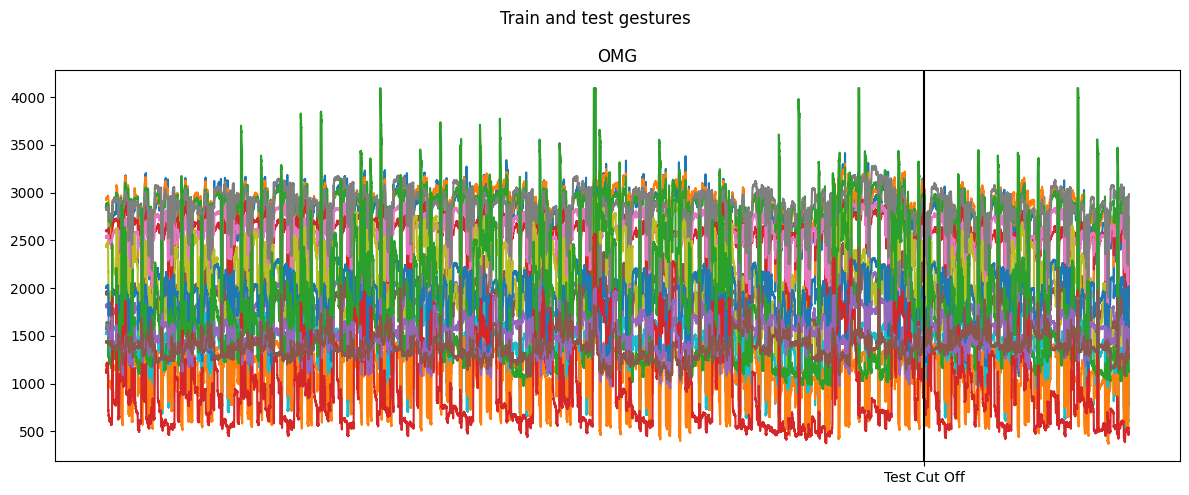

In [23]:
fig, axx = plt.subplots(1, 1, sharex=True, figsize=(12, 5))
xax = np.arange(train_data.shape[0])
#plt.sca(axx[0])
plot_train = plt.plot(xax, train_data[high_ch].values)
#plot_train = plt.plot(gestures_train['ts'].values, gestures_train[OMG_CH].values)
plt.axvline(train_size, color='k', label='Train-Test split')
plt.xticks( ticks=[train_size], labels=["Test Cut Off"])
plt.title('OMG')
plt.suptitle('Train and test gestures')
plt.tight_layout()

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# file paths for sliced data
train_path  = "./ENC_Train.npy"
target_path = "./ENC_Target.npy"
test_path   = "./ENC_Test.npy"
true_path = "./ENC_True.npy"
#  If there will be N units in RNN, than 
slice_step = 100   #Not more than N/2
slice_len = 400   #Not less than N * 2

print(train_data[high_ch].shape)
# Min Max Scalling of selected OMG channels
X_orig_train = scaler.fit_transform(train_data[high_ch].values)
print(X_orig_train.shape)

X_train = X_orig_train[:train_size,:]
Y_train = train_data[ENC_CH].values[:train_size,:]
X_test = X_orig_train[train_size:,:]
print("Train Shape X:", X_train.shape)
print("Test Shape X:", X_test.shape)
print('-'*10)
Y_test = train_data[ENC_CH].values[train_size:,:]
print("Trein Shape y:",Y_train.shape)
print("Test Shape y:",Y_test.shape)
print('-'*10)




#Slicing train data
x_start = 0
x_max = X_train.shape[0] - slice_len
train = list()
target = list()
while x_start <= x_max:
    r = x_start+slice_len
    train.append(X_train[x_start:r,:])
    target.append(Y_train[x_start:r,:])
    x_start += slice_step
# converting lists to np arrays
prep_train = np.stack(train,axis=0)
print("Train Shape",prep_train.shape)
prep_targ = np.stack(target,axis=0)
print("Target Shape",prep_targ.shape)
# saving prepared data
np.save(train_path,prep_train)
np.save(target_path,prep_targ)
np.save(test_path, X_test)
np.save(true_path,Y_test)
'''
x_start = 0
x_max = X_train.shape[0] - slice_len
train = list()
target = list()
Здесь переменная x_start инициализируется значением 0, которое представляет собой начальный индекс подпоследовательности в данных X_train. Затем переменная x_max вычисляется как максимальный индекс таким образом, что x_max = X_train.shape[0] - slice_len. Это гарантирует, что последняя возможная подпоследовательность может быть создана без выхода за границы данных X_train.

Списки train и target инициализируются для хранения подпоследовательностей из X_train и Y_train соответственно.

while x_start <= x_max:
    r = x_start + slice_len
    train.append(X_train[x_start:r, :])
    target.append(Y_train[x_start:r, :])
    x_start += slice_step
Этот цикл while выполняется до тех пор, пока x_start меньше или равно x_max. В каждой итерации из данных X_train и Y_train извлекается подпоследовательность длиной slice_len, начиная с индекса x_start и заканчивая индексом r = x_start + slice_len. Затем эта подпоследовательность добавляется в список train, а соответствующая подпоследовательность из Y_train добавляется в список target.

Затем значение x_start увеличивается на slice_step, который определяет шаг между последовательными подпоследовательностями. Это позволяет создавать неперекрывающиеся или перекрывающиеся подпоследовательности в зависимости от значения slice_step. Цикл продолжается, пока значение x_start не превысит x_max, гарантируя создание всех возможных подпоследовательностей.

В итоге, данный код создает несколько подпоследовательностей длиной slice_len из данных X_train и Y_train, с определенным шагом slice_step. Эти подпоследовательности сохраняются в списках train и target соответственно. Цикл выполняется до тех пор, пока не будут созданы все возможные подпоследовательности.


'''




(37610, 16)
(37610, 16)
Train Shape X: (30088, 16)
Test Shape X: (7522, 16)
----------
Trein Shape y: (30088, 5)
Test Shape y: (7522, 5)
----------
Train Shape (297, 400, 16)
Target Shape (297, 400, 5)


'\nx_start = 0\nx_max = X_train.shape[0] - slice_len\ntrain = list()\ntarget = list()\nЗдесь переменная x_start инициализируется значением 0, которое представляет собой начальный индекс подпоследовательности в данных X_train. Затем переменная x_max вычисляется как максимальный индекс таким образом, что x_max = X_train.shape[0] - slice_len. Это гарантирует, что последняя возможная подпоследовательность может быть создана без выхода за границы данных X_train.\n\nСписки train и target инициализируются для хранения подпоследовательностей из X_train и Y_train соответственно.\n\nwhile x_start <= x_max:\n    r = x_start + slice_len\n    train.append(X_train[x_start:r, :])\n    target.append(Y_train[x_start:r, :])\n    x_start += slice_step\nЭтот цикл while выполняется до тех пор, пока x_start меньше или равно x_max. В каждой итерации из данных X_train и Y_train извлекается подпоследовательность длиной slice_len, начиная с индекса x_start и заканчивая индексом r = x_start + slice_len. Затем эт

In [25]:
train = np.load(train_path)
target = np.load(target_path)
test = np.load(test_path)
truth = np.load(true_path)
N_OMG = train.shape[2]
N_OUT = target.shape[2]

# Modeling

## Model planning

In [26]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 

CH = ['ENC0','ENC1', 'ENC2', 'ENC3', 'ENC4']
MODEL_FN = './Models/ENC_model01.hdf5'

RANDOM_SEED = 19

## !!!

In [27]:
#print(f"input_shape = {(n_ts, n_chan)} | output_units = {out_units}")  #n_ts
input_channels = x = tf.keras.layers.Input(shape=(None, N_OMG)) #n_ts

x = tf.keras.layers.BatchNormalization()(input_channels)

# добавляем слой LSTM с return_sequences=True для авторегрессии
x = tf.keras.layers.LSTM(units=200, return_sequences=True, recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-2))(x)
x = tf.keras.layers.Dropout(rate=0.2)(x)

# # добавляем еще один слой LSTM
# x = tf.keras.layers.LSTM(units=100, return_sequences=True, recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-2))(x)
# x = tf.keras.layers.Dropout(rate=0.2)(x)

# добавляем слой GRU
x = tf.keras.layers.GRU(units=50, return_sequences=True, recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-2))(x)
x = tf.keras.layers.Dropout(rate=0.3)(x)

# добавляем полносвязный слой
x = tf.keras.layers.Dense(units=100, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.2)(x)



output = tf.keras.layers.Dense(units=N_OUT, activation='relu', bias_regularizer=tf.keras.regularizers.l2(1e-4), activity_regularizer=tf.keras.regularizers.l2(1e-5))(x)

model_struct = tf.keras.Model(
    inputs=input_channels,
    outputs=output,
    name="ENC_Model"
)

model_struct.summary()

Model: "ENC_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 16)]        0         
                                                                 
 batch_normalization_1 (Batc  (None, None, 16)         64        
 hNormalization)                                                 
                                                                 
 lstm_1 (LSTM)               (None, None, 200)         173600    
                                                                 
 dropout (Dropout)           (None, None, 200)         0         
                                                                 
 gru (GRU)                   (None, None, 50)          37800     
                                                                 
 dropout_1 (Dropout)         (None, None, 50)          0         
                                                         

# Генина сеть

In [28]:
# #print(f"input_shape = {(n_ts, n_chan)} | output_units = {out_units}")  #n_ts
# input_channels = x = tf.keras.layers.Input(shape=(None, N_OMG)) #n_ts

# x = tf.keras.layers.SimpleRNN( units=50, activation='relu', return_sequences=True, 
#                               recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-2), )(x)
# # x = tf.keras.layers.Dropout(0.1)(x)
# x = tf.keras.layers.TimeDistributed(
#     tf.keras.layers.Dense(units=30, activation='relu', bias_regularizer=tf.keras.regularizers.l2(1e-4), activity_regularizer=tf.keras.regularizers.l2(1e-5)))(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dropout(0.25)(x)
# #x = tf.keras.layers.Dense(units=30, activation='relu', bias_regularizer=tf.keras.regularizers.l2(1e-4), activity_regularizer=tf.keras.regularizers.l2(1e-5))(x)
# #x = tf.keras.layers.BatchNormalization()(x)
# #x = tf.keras.layers.Dropout(0.25)(x)

# output = tf.keras.layers.Dense(units=N_OUT, activation='relu', bias_regularizer=tf.keras.regularizers.l2(1e-4), activity_regularizer=tf.keras.regularizers.l2(1e-5))(x)

# model_struct = tf.keras.Model(
#     inputs=input_channels,
#     outputs=output,
#     name="ENC_Model"
# )

# model_struct.summary()

In [29]:
save_best = tf.keras.callbacks.ModelCheckpoint(MODEL_FN, monitor='val_mse', verbose=0, mode='min', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping( monitor='val_mse', patience=50, restore_best_weights=True) 
callbacks=[save_best, early_stopping]

## Model Training

Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Epoch 12/200
Epoch 13/200
Epoch 14/200
Epoch 15/200
Epoch 16/200
Epoch 17/200
Epoch 18/200
Epoch 19/200
Epoch 20/200
Epoch 21/200
Epoch 22/200
Epoch 23/200
Epoch 24/200
Epoch 25/200
Epoch 26/200
Epoch 27/200
Epoch 28/200
Epoch 29/200
Epoch 30/200
Epoch 31/200
Epoch 32/200
Epoch 33/200
Epoch 34/200
Epoch 35/200
Epoch 36/200
Epoch 37/200
Epoch 38/200
Epoch 39/200
Epoch 40/200
Epoch 41/200
Epoch 42/200
Epoch 43/200
Epoch 44/200
Epoch 45/200
Epoch 46/200
Epoch 47/200
Epoch 48/200
Epoch 49/200
Epoch 50/200
Epoch 51/200
Epoch 52/200
Epoch 53/200
Epoch 54/200
Epoch 55/200
Epoch 56/200
Epoch 57/200
Epoch 58/200
Epoch 59/200
Epoch 60/200
Epoch 61/200
Epoch 62/200
Epoch 63/200
Epoch 64/200
Epoch 65/200
Epoch 66/200
Epoch 67/200
Epoch 68/200
Epoch 69/200
Epoch 70/200
Epoch 71/200
Epoch 72/200
Epoch 73/200
Epoch 74/200
Epoch 75/200
Epoch 76/200
Epoch 77/200
Epoch 78

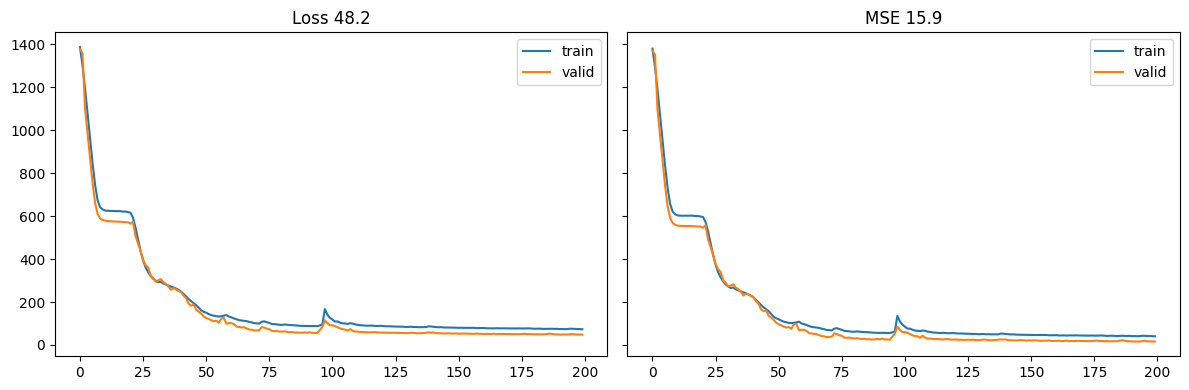

In [30]:
X_trn, X_val, Y_trn, Y_val = train_test_split(train, target, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)
tf.keras.utils.set_random_seed(RANDOM_SEED)

model = tf.keras.models.clone_model(model_struct)
model.compile( loss= 'mse', metrics= ['mse'], optimizer=tf.keras.optimizers.Adam(), )

hist = model.fit( X_trn, Y_trn, epochs=200, verbose=-1, validation_data= (X_val, Y_val), callbacks= callbacks) 

h = hist.history
model.load_weights(MODEL_FN)
vloss = str(round(np.min(h['val_loss']),1))
vmse = str(round(np.min(h['val_mse']),1))
print("Val Loss",vloss, "Val MSE", vmse )

#vloss = str(round(np.min(h['val_loss']),1))
#vmse = str(round(np.min(h['val_mse']),1))
fig, axx = plt.subplots(1,2, figsize=(12,4),sharey=True)
axx[0].plot(h['loss'], label='train')
axx[0].plot(h['val_loss'], label = 'valid')
axx[0].set_title('Loss '+vloss)
axx[0].legend(loc='best')
axx[1].plot(h['mse'], label = 'train')
axx[1].plot(h['val_mse'], label = 'valid')
axx[1].set_title('MSE '+vmse)
axx[1].legend(loc='best')
plt.tight_layout()
plt.show();
    


## Prediction and Metrics

In [31]:
#Predict Test data
x_test = np.expand_dims(test, axis=0)
y_pred = np.reshape(model.predict(x_test, verbose=0),(-1,N_OUT))
print("Test MSE")
for i in range(len(CH)):
    print(CH[i], round(mean_squared_error(truth[:,i],y_pred[:,i]),2))
print("Average", round(mean_squared_error(truth, y_pred),2) )

Test MSE
ENC0 27.91
ENC1 22.26
ENC2 32.36
ENC3 39.23
ENC4 46.86
Average 33.72


In [32]:
# #Predict Test data
# x_test = np.expand_dims(test, axis=0)
# y_pred = np.reshape(model.predict(x_test, verbose=0),(-1,N_OUT))
# print("Test MSE")
# for i in range(len(CH)):
#     print(CH[i], round(mean_squared_error(truth[:,i],y_pred[:,i]),2))
# print("Average", round(mean_squared_error(truth, y_pred),2) )

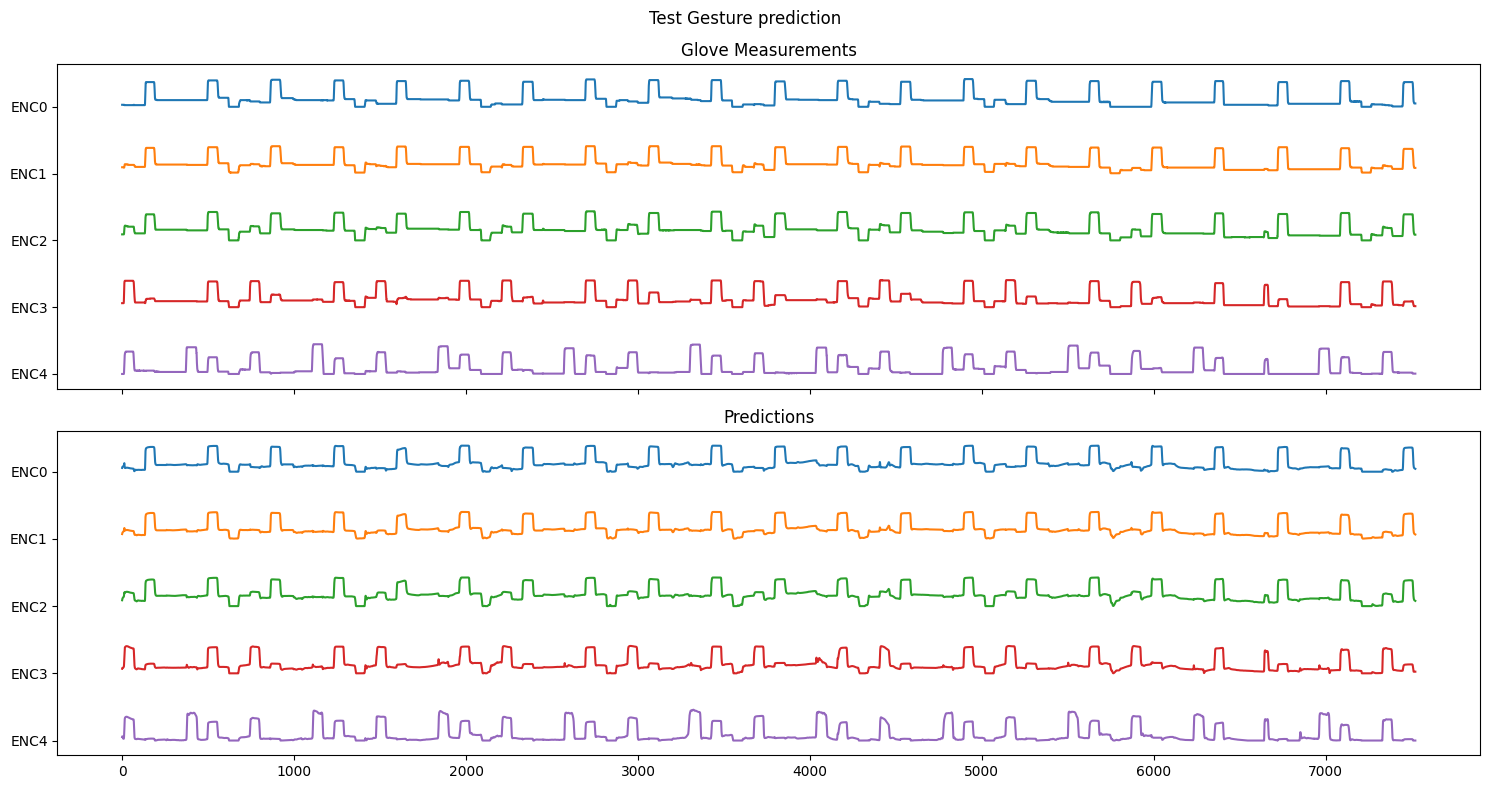

In [33]:
x_axis = np.arange(truth.shape[0])
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(15, 8))
plt.sca(axx[0])
plt.plot(x_axis, truth - np.arange(len(CH)) * 200)
plt.yticks(-np.arange(len(CH)) * 200, CH)
#plt.legend()
plt.title('Glove Measurements')
plt.sca(axx[1])
plt.plot(x_axis, y_pred - np.arange(len(CH)) * 200)
plt.yticks(-np.arange(len(CH)) * 200, CH)
#plt.legend()
plt.title('Predictions')
plt.suptitle('Test Gesture prediction')
plt.tight_layout()


## Duplicating Model for Serial Inference

In [34]:
model.summary()

Model: "ENC_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 16)]        0         
                                                                 
 batch_normalization_1 (Batc  (None, None, 16)         64        
 hNormalization)                                                 
                                                                 
 lstm_1 (LSTM)               (None, None, 200)         173600    
                                                                 
 dropout (Dropout)           (None, None, 200)         0         
                                                                 
 gru (GRU)                   (None, None, 50)          37800     
                                                                 
 dropout_1 (Dropout)         (None, None, 50)          0         
                                                         

In [36]:
model_input = tf.keras.Input(batch_shape=(1, 1, N_OMG))

x = tf.keras.layers.BatchNormalization()(model_input)

# добавляем слой LSTM с return_sequences=True для авторегрессии
x = tf.keras.layers.LSTM(units=200, return_sequences=True, stateful=True)(x)
x = tf.keras.layers.Dropout(rate=0.2)(x)

# # добавляем еще один слой LSTM
# x = tf.keras.layers.LSTM(units=100, return_sequences=True)(x)
# x = tf.keras.layers.Dropout(rate=0.2)(x)

# добавляем слой GRU
x = tf.keras.layers.GRU(units=50, return_sequences=True, stateful=True)(x)
x = tf.keras.layers.Dropout(rate=0.3)(x)

# добавляем полносвязный слой
x = tf.keras.layers.Dense(units=100, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.2)(x)
model_output = tf.keras.layers.Dense(N_OUT, activation='relu')(x)

model_stateful = tf.keras.Model(
    inputs=[model_input],
    outputs=[model_output],
    name='ENC_model_stateful'
)

model_stateful.set_weights(model.get_weights())
print(model_stateful.summary())


Model: "ENC_model_stateful"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(1, 1, 16)]              0         
                                                                 
 batch_normalization_3 (Batc  (1, 1, 16)               64        
 hNormalization)                                                 
                                                                 
 lstm_3 (LSTM)               (1, 1, 200)               173600    
                                                                 
 dropout_4 (Dropout)         (1, 1, 200)               0         
                                                                 
 gru_1 (GRU)                 (1, 1, 50)                37800     
                                                                 
 dropout_5 (Dropout)         (1, 1, 50)                0         
                                                

## Verifying Serial Statefull Model

In [37]:
import time

In [38]:
%%time
model_stateful.reset_states()
y_pred_statefull = list()
n_iter = x_test.shape[1]
start_time = time.time()
for i in range(n_iter):
    x = x_test[0,i,:].reshape((1,1,-1))
    y = model_stateful(x,training=False).numpy()
    y_pred_statefull.append(y)
end_time = time.time()
av_duration = (end_time - start_time)/n_iter * 1000  #convert to mSec 
y_pred_statefull = np.hstack(y_pred_statefull).reshape((-1,N_OUT))
print("Statefull prediction Shape:", y_pred_statefull.shape)
print(f"Avg time of {n_iter} iters: {av_duration:.2f} mSec")



Statefull prediction Shape: (7522, 5)
Avg time of 7522 iters: 11.55 mSec
CPU times: total: 1min 3s
Wall time: 1min 26s


In [39]:
# CHECK equality of predictions
print("Two predictions are close:", np.allclose( y_pred[:,0], y_pred_statefull[:,0], atol=0.001))
print("MSE of predictions", mean_squared_error(y_pred,y_pred_statefull))


Two predictions are close: True
MSE of predictions 2.7592095e-11


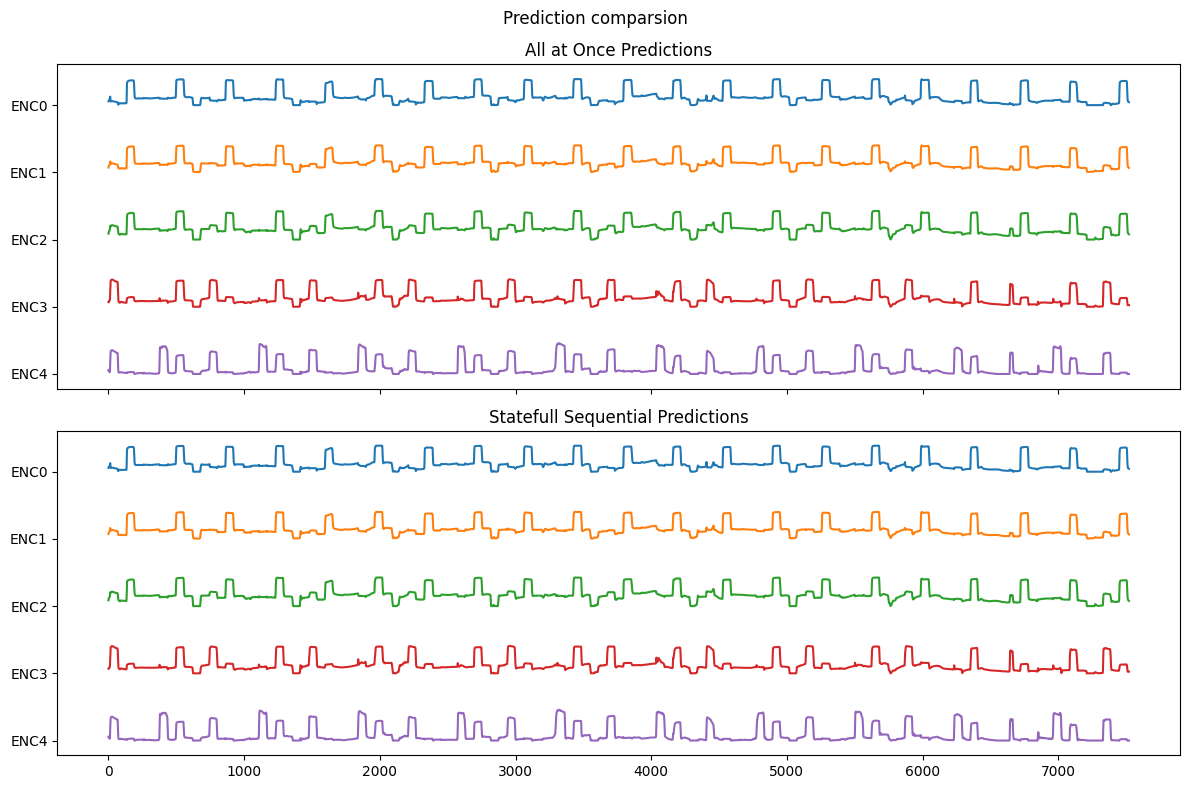

In [40]:
x_axis = np.arange(truth.shape[0])
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
plt.sca(axx[0])
plt.plot(x_axis, y_pred - np.arange(len(CH)) * 200)
plt.yticks(-np.arange(len(CH)) * 200, CH)
#plt.legend()
plt.title('All at Once Predictions')
plt.sca(axx[1])
plt.plot(x_axis, y_pred_statefull - np.arange(len(CH)) * 200)
plt.yticks(-np.arange(len(CH)) * 200, CH)
#plt.legend()
plt.title('Statefull Sequential Predictions')
plt.suptitle('Prediction comparsion')
plt.tight_layout()

In [41]:
# Comment if you do not want to stop here! 
# assert False

# Real-time inference

In [42]:
import time
from IPython.display import clear_output

In [43]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

## Inference Utils: Put your code here

In [44]:
def preprocessing(x):
    # x - sample vector
    x = np.delete(x,ch_to_delete)
    y = scaler.transform(x.reshape(1,-1)).flatten()
    return y

def inference(x):
    y = model_stateful(x.reshape((1,1,-1)),training=False).numpy().flatten()
    return y

def postprocessing(x, prev):
    if prev is None:  
        prev = x.copy()
    
    y = x*0.1 + prev*0.9 # Holt-Winters filter
    return y

def commands(x):
    y = np.clip(x, 0, 100).astype(int) #np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y

## Inference

### Offline (dataset)

In [45]:
df_sim = gestures_train.copy().iloc[:10000]
# df_sim = free_movements.iloc[:10000]
print("Simulation Data Shape", df_sim.shape)

Simulation Data Shape (10000, 65)


omg_sample.shape = (10000, 50)
enc_sample.shape = (10000, 6)
sample_preprocessed.shape = (10000, 16)
y_predicted.shape = (10000, 5)
y_postprocessed.shape = (10000, 5)
y_commands.shape = (10000, 5)
duration.shape = (10000,)
Average observation processing duration 11.762034845352172 mSec


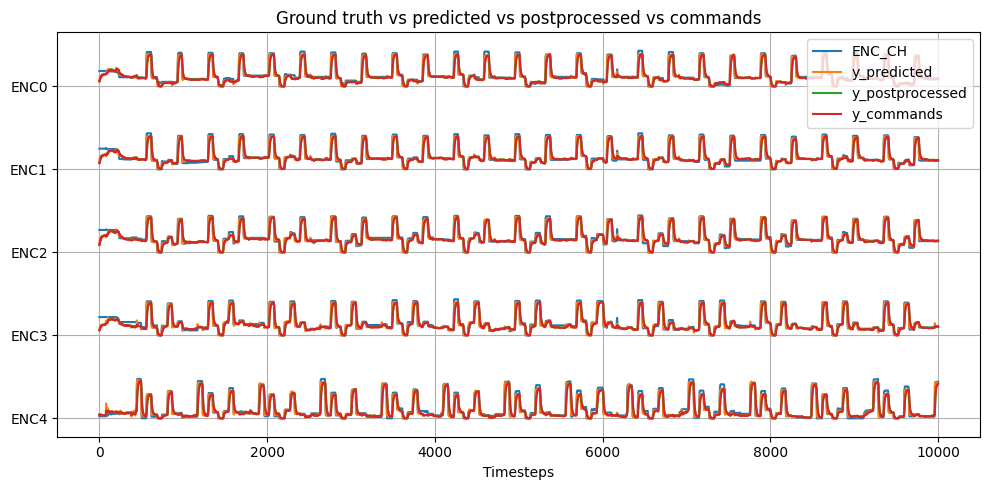

In [46]:
TIMEOUT = 0.033
DEBUG = False
    
i = 0


model_stateful.reset_states()

y_previous = None

y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
    'duration': [],
}

ts_old = time.time()
ts_diff = 0;

while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    y_dct['duration'].append(ts_diff*1000)
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 



for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

print("Average observation processing duration", y_dct['duration'].mean(),"mSec")


fig = plt.figure(figsize=(10, 5))

lines = []
labels = []

plots = plt.plot(df_sim[ENC_CH].values - np.arange(len(ENC_CH)) * 200, c='C0')
lines += [plots[0]]
labels += ['ENC_CH']

plots = plt.plot(y_dct['y_predicted'] - np.arange(len(ENC_CH)) * 200, c='C1')
lines += [plots[0]]
labels += ['y_predicted']

plots = plt.plot(y_dct['y_postprocessed'] - np.arange(len(ENC_CH)) * 200, c='C2')
lines += [plots[0]]
labels += ['y_postprocessed']

plots = plt.plot(y_dct['y_commands'] - np.arange(len(ENC_CH)) * 200, c='C3')
lines += [plots[0]]
labels += ['y_commands']

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(-np.arange(len(ENC_CH)) * 200, ENC_CH)
plt.legend(lines, labels)
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

### Online (prosthesis or virtual hand)

In [47]:
"""
# Uncomment to run

import serial

TIMEOUT = 0.033
DEBUG = True

model_stateful.reset_states()

ser = None
# ser_port = None
# ser_port = '/dev/ttyACM0'
ser_port = '/dev/cu.usbmodem3498365F31351'

if ser_port is not None:
    ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
    ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
    ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
    ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

    # flush buffers
    ser.reset_input_buffer()
    ser.read()
    
    i = 0;
    while(ser.in_waiting):
        print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
        ser.read_all()
        time.sleep(0.005)
        i+=1;
    ser.readline()
    ser.readline()
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
while True:    
    
    # [Data reading]
    s = ser.readline()
    ts_start = time.time()
    
    try:
        sample = np.array(s.decode('UTF-8')\
                           .replace('\r\n', "")\
                           .split(' ')
                         ).astype(int)
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
    # [/Commands sending]
    
    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
        print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
        print('INPUT:\n', s)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
        print(pack)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

"""

'\n# Uncomment to run\n\nimport serial\n\nTIMEOUT = 0.033\nDEBUG = True\n\nmodel_stateful.reset_states()\n\nser = None\n# ser_port = None\n# ser_port = \'/dev/ttyACM0\'\nser_port = \'/dev/cu.usbmodem3498365F31351\'\n\nif ser_port is not None:\n    ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)\n    ser.write(\'T1#\r\n\'.encode(\'utf-8\')) # T1 for Timestamp activate\n    ser.write(\'M2#\r\n\'.encode(\'utf-8\')) # M2 for Mode == 2 = send samples\n    ser.write(\'S2#\r\n\'.encode(\'utf-8\')) # SYNC to 2 for sanity check\n\n    # flush buffers\n    ser.reset_input_buffer()\n    ser.read()\n    \n    i = 0;\n    while(ser.in_waiting):\n        print(f\'Flushing buffers {i}: {ser.in_waiting}\', end=\'    \r\')\n        ser.read_all()\n        time.sleep(0.005)\n        i+=1;\n    ser.readline()\n    ser.readline()\n    \ni = 0\nts_old = time.time()\nts_diff = 0;\n\ny_previous = None\nwhile True:    \n    \n    # [Data reading]\n    s = ser.readline()\n    ts_start = time.time()\n    